## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocessing import Pool, cpu_count
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## OR and AND Gates

#### Series

In [2]:
s = pd.Series([True, False, True, False, False])

s.all()


False

In [3]:
s.any()

True

In [4]:
s == s

0    True
1    True
2    True
3    True
4    True
dtype: bool

## Test DC-classification

#### data

In [5]:
## Observations
dataE = {
    # protocol_type
    'pt_udp':   [1, 0, 0, 0, 0,      1, 1, 1, 0, 0, 0],
    'pt_tcp':   [0, 1, 1, 1, 0,      0, 0, 0, 0, 0, 0],
    'pt_icmp':  [0, 0, 0, 0, 1,      0, 0, 0, 1, 1, 1],
    # service_type
    's_other':  [1, 0, 0, 0, 0,      0, 0, 0, 0, 0, 0],
    's_http':   [0, 1, 1, 0, 0,      1, 1, 1, 0, 0, 0],
    's_private':[0, 0, 0, 1, 1,      0, 0, 0, 1, 1, 1],
    # flag_type
    'f_SF':     [1, 1, 1, 0, 0,      1, 0, 0, 1, 0, 0],
    'f_S0':     [0, 0, 0, 1, 0,      0, 1, 0, 0, 1, 0],
    'f_REJ':    [0, 0, 0, 0, 1,      0, 0, 1, 0, 0, 1],
    # outputs        Benign             Malicious |===> (UDP && HTTP(3)) || (ICMP && Private(2))   
    'outcome':  [0, 0, 0, 0, 0,      1, 1, 1, 1, 1, 0],  # (except ICMP.Private.REJ (E{11}  ==  B{5} == E{5}))
    'predicted':[1, 1, 1, 1, 1,      1, 1, 1, 1, 1, 1]  ## --> initialize predictions to 1
}

## Valient Constraints Satisfiable Solutions
dataBenign = { 
    # protocol_type
    'pt_udp':   [1, 0, 0, 0, 0],
    'pt_tcp':   [0, 1, 1, 1, 0],
    'pt_icmp':  [0, 0, 0, 0, 1],
    # service_type
    's_other':  [1, 0, 0, 0, 0],
    's_http':   [0, 1, 1, 0, 0],
    's_private':[0, 0, 0, 1, 1],
    # flag_type
    'f_SF':     [1, 1, 1, 0, 0],
    'f_S0':     [0, 0, 0, 1, 0],
    'f_REJ':    [0, 0, 0, 0, 1],
}
 

In [6]:
# Convert the dictionary into DataFrame 
E = pd.DataFrame(dataE, index=[f'observation-{i+1}' for i in range(11)])
E

,pt_udp,pt_tcp,pt_icmp,s_other,s_http,s_private,f_SF,f_S0,f_REJ,outcome,predicted
observation-1,1,0,0,1,0,0,1,0,0,0,1
observation-2,0,1,0,0,1,0,1,0,0,0,1
observation-3,0,1,0,0,1,0,1,0,0,0,1
observation-4,0,1,0,0,0,1,0,1,0,0,1
observation-5,0,0,1,0,0,1,0,0,1,0,1
observation-6,1,0,0,0,1,0,1,0,0,1,1
observation-7,1,0,0,0,1,0,0,1,0,1,1
observation-8,1,0,0,0,1,0,0,0,1,1,1
observation-9,0,0,1,0,0,1,1,0,0,1,1
observation-10,0,0,1,0,0,1,0,1,0,1,1


In [7]:
# Convert the dictionary into DataFrame 
B = pd.DataFrame(dataBenign, index=[f'satisfiable-{i+1}' for i in range(5)])
B

,pt_udp,pt_tcp,pt_icmp,s_other,s_http,s_private,f_SF,f_S0,f_REJ
satisfiable-1,1,0,0,1,0,0,1,0,0
satisfiable-2,0,1,0,0,1,0,1,0,0
satisfiable-3,0,1,0,0,1,0,1,0,0
satisfiable-4,0,1,0,0,0,1,0,1,0
satisfiable-5,0,0,1,0,0,1,0,0,1


In [8]:
## Columns

features = E.columns.tolist()
print(features)

input_features = features[0:-2]
print(input_features)

output_features = features[-2:]
print(output_features)

['pt_udp', 'pt_tcp', 'pt_icmp', 's_other', 's_http', 's_private', 'f_SF', 'f_S0', 'f_REJ', 'outcome', 'predicted']
['pt_udp', 'pt_tcp', 'pt_icmp', 's_other', 's_http', 's_private', 'f_SF', 'f_S0', 'f_REJ']
['outcome', 'predicted']


#### classification (single-threads)

In [9]:
# for ie, e in tqdm(E.iterrows(), total=E.shape[0], desc='DC Classification (ST)', unit='observations'):
#     for ib, b in B.iterrows():
#         if((e[input_features] == b[input_features]).all()):  # benign rows belong to the solution of the SaPC
#             E.loc[ie, 'predicted'] = 0
#             print(f'{ie} - ', end='')

#### classification (multi-threads)

In [10]:
'''       Classify all samples (Alg.)    '''
def dc_predict(observations):
    for ie, e in tqdm(observations.iterrows(), total=observations.shape[0], desc='DC Classification (MT)', unit='observations'): 
        for ib, b in B.iterrows():
            if((e[input_features] == b[input_features]).all()):  # benign rows belong to the solution of the SaPC
                E.loc[ie, 'predicted'] = 0
                # print(f'{ie} - ', end='')

    return observations
    

In [11]:
'''       Split the dataframe in {num_processes} chunks    '''
## create as many processes as there are CPUs on your machine
num_processes = cpu_count() - 12

## calculate the chunk size as an integer
chunk_size = int(E.shape[0]/num_processes)

## Split the dataframe in chunk_size,   will work even if the length of the dataframe is not evenly divisible by num_processes
# for i in range(0, E.shape[0], chunk_size):
#     print(f'[{i}:{i+chunk_size}]')
chunks = [E.iloc[i:i + chunk_size] for i in range(0, E.shape[0], chunk_size)]

(chunk_size, len(chunks))

(2, 6)

In [12]:
'''       Threads launching    '''
# create our pool with `num_processes` processes
pool = Pool(processes=num_processes)

# apply our function to each chunk in the list
result = pool.map(dc_predict, iterable=chunks)
pool.close()

# result

In [13]:
for i in range(len(result)):
   E.loc[result[i].index] = result[i]


E

,pt_udp,pt_tcp,pt_icmp,s_other,s_http,s_private,f_SF,f_S0,f_REJ,outcome,predicted
observation-1,1,0,0,1,0,0,1,0,0,0,1
observation-2,0,1,0,0,1,0,1,0,0,0,1
observation-3,0,1,0,0,1,0,1,0,0,0,1
observation-4,0,1,0,0,0,1,0,1,0,0,1
observation-5,0,0,1,0,0,1,0,0,1,0,1
observation-6,1,0,0,0,1,0,1,0,0,1,1
observation-7,1,0,0,0,1,0,0,1,0,1,1
observation-8,1,0,0,0,1,0,0,0,1,1,1
observation-9,0,0,1,0,0,1,1,0,0,1,1
observation-10,0,0,1,0,0,1,0,1,0,1,1


#### results

In [14]:
'''       Predictions    '''

E[E['predicted'] == 0]

,pt_udp,pt_tcp,pt_icmp,s_other,s_http,s_private,f_SF,f_S0,f_REJ,outcome,predicted


In [15]:
E[E['predicted'] == 1]

,pt_udp,pt_tcp,pt_icmp,s_other,s_http,s_private,f_SF,f_S0,f_REJ,outcome,predicted
observation-1,1,0,0,1,0,0,1,0,0,0,1
observation-2,0,1,0,0,1,0,1,0,0,0,1
observation-3,0,1,0,0,1,0,1,0,0,0,1
observation-4,0,1,0,0,0,1,0,1,0,0,1
observation-5,0,0,1,0,0,1,0,0,1,0,1
observation-6,1,0,0,0,1,0,1,0,0,1,1
observation-7,1,0,0,0,1,0,0,1,0,1,1
observation-8,1,0,0,0,1,0,0,0,1,1,1
observation-9,0,0,1,0,0,1,1,0,0,1,1
observation-10,0,0,1,0,0,1,0,1,0,1,1


#### confusion matrix

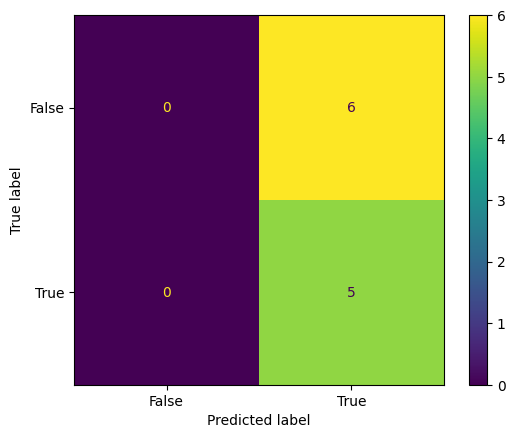

In [16]:
cm = confusion_matrix(E['outcome'].values, E['predicted'].values)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot()
plt.show()

[[0 6]
 [0 5]]


/tmp/ipykernel_89579/2054728942.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_89579/2054728942.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


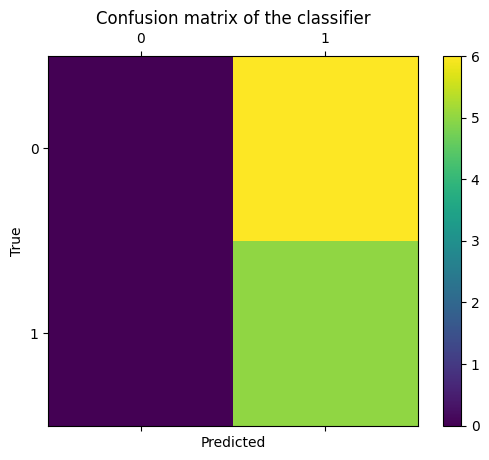

In [17]:
labels = [0, 1]

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()